In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, MultiHeadAttention, Add, GlobalAveragePooling1D, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K

In [2]:
# Charge X and y data that are in .npy format
X = np.load('../../../save_model/X.npy')
y = np.load('../../../save_model/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [3]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((153, 300, 30), (39, 300, 30), (49, 300, 30), (153,), (39,), (49,))

In [4]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [5]:
# Parámetros
n_components = 30
n_models = 1
components_per_model = 30

models = []
selected_components = []
histories = []

# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    x = Add()([x, ff])  # Skip connection
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Opción: Preprocesamiento con Conv1D (opcional)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Dropout(0.3)(x)

    # Transformer Encoder
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

    # Pooling + Dense
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model

# Training of emsemble
for i in range(n_models):
    print(f"Entrenando modelo {i+1}/{n_models}")
    
    components_idx = np.random.choice(n_components, components_per_model, replace=False)
    selected_components.append(components_idx)
    
    # Seleccionamos esos componentes
    X_train_selected = X_train[:, :, components_idx]  # (samples, 300, components_per_model)
    X_val_selected = X_val[:, :, components_idx]

    # Creamos y entrenamos el modelo
    model = build_transformer_model((X_train_selected.shape[1], X_train_selected.shape[2]))
    
    history = model.fit(
        X_train_selected,
        y_train,
        class_weight=class_weights,
        epochs=500,
        batch_size=32,
        validation_data=(X_val_selected, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    models.append(model)
    histories.append(history)

Entrenando modelo 1/1
Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.2672 - loss: 1.5241 - val_accuracy: 0.1538 - val_loss: 1.4310 - learning_rate: 1.0000e-04
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.2317 - loss: 1.4865 - val_accuracy: 0.1795 - val_loss: 1.3986 - learning_rate: 1.0000e-04
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.2455 - loss: 1.4535 - val_accuracy: 0.2564 - val_loss: 1.3827 - learning_rate: 1.0000e-04
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.2912 - loss: 1.4373 - val_accuracy: 0.3077 - val_loss: 1.3668 - learning_rate: 1.0000e-04
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.2121 - loss: 1.4459 - val_accuracy: 0.2821 - val_loss: 1.3636 - learning_rate: 1.0000e-04
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.2951 - loss: 1.3945 - val_accuracy: 0.2564 - val_loss: 1.3680 - learning_rate: 1.0000e-04
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/st

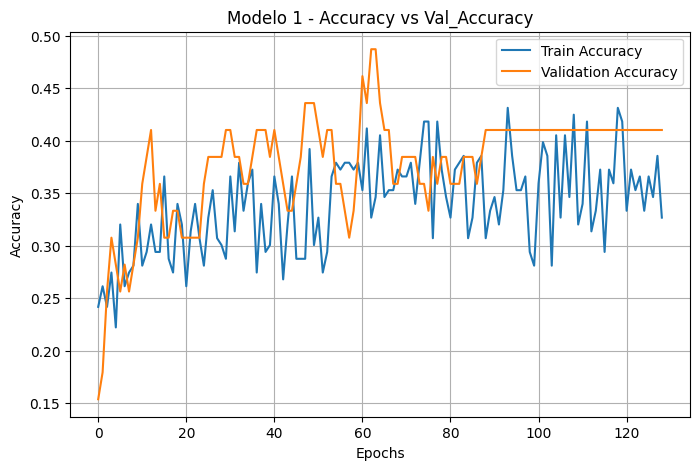

In [6]:
# Accuracy vs Val_Accuracy of each model
for i, history in enumerate(histories):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Modelo {i+1} - Accuracy vs Val_Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Predicciones individuales de cada modelo
all_model_preds = []

for idx, model in enumerate(models):
    components_idx = selected_components[idx]
    X_test_selected = X_test[:, :, components_idx]
    preds = model.predict(X_test_selected)
    all_model_preds.append(preds)

# Stack of predictions
all_model_preds = np.stack(all_model_preds, axis=0)
avg_preds = np.mean(all_model_preds, axis=0)
final_preds = np.argmax(avg_preds, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


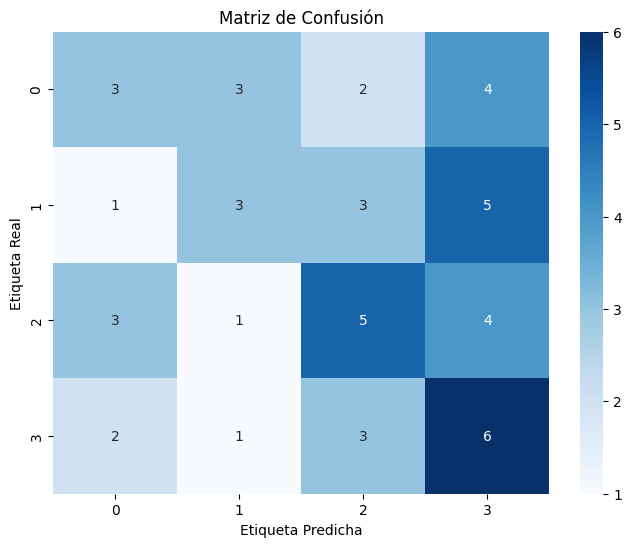

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [9]:
# Classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.333     0.250     0.286        12
           1      0.375     0.250     0.300        12
           2      0.385     0.385     0.385        13
           3      0.316     0.500     0.387        12

    accuracy                          0.347        49
   macro avg      0.352     0.346     0.339        49
weighted avg      0.353     0.347     0.340        49

